In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os
import datetime

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
maindir = "C:\\Users\\jliang\\Desktop\\Zillow\\Zillow"

## Reading in the Data 

In [23]:
logerror = pd.read_csv(maindir + "\\data\\train_2016_v2.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)

properties = pd.read_csv(maindir + "\\data\\properties_2016.csv")
test_parcels = pd.read_csv(maindir + "\\data\\sample_submission.csv", usecols = ['ParcelId'])
test_parcels.rename(columns={'ParcelId':'parcelid'}, inplace=True)

# join on parcel id
data = pd.merge(properties,logerror[['parcelid','logerror','month']], on='parcelid')

C:\Users\Jliang\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
logerror.head()

,parcelid,logerror,transactiondate,weeknumber,month
0,11016594,0.0276,2016-01-01,53,1
1,14366692,-0.1684,2016-01-01,53,1
2,12098116,-0.0040,2016-01-01,53,1
3,12643413,0.0218,2016-01-02,53,1
4,14432541,-0.0050,2016-01-02,53,1


In [24]:
logerror['transactiondate'] = pd.to_datetime(logerror['transactiondate'])

In [46]:
logerror['yr_mon'] = np.where(logerror['transactiondate'].dt.month.astype(int) < 10, \
                              logerror['transactiondate'].dt.year.astype(str)+'0'+logerror['transactiondate'].dt.month.astype(str),\
                              logerror['yr_mon'] = logerror['transactiondate'].dt.year.astype(str)+logerror['transactiondate'].dt.month.astype(str))  
logerror['yr_mon']

SyntaxError: keyword can't be an expression (<ipython-input-46-00b9dbd8589f>, line 1)

In [15]:
logerror.dtypes

parcelid                    int64
logerror                  float64
transactiondate    datetime64[ns]
weeknumber                  int64
month                       int64
dtype: object

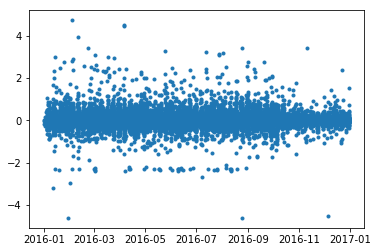

In [16]:
plt.plot(logerror['transactiondate'],logerror['logerror'],'.')

In [5]:
logerror.parcelid.nunique()

90150

In [6]:
properties.parcelid.nunique()

2985217

In [7]:
properties.shape

(2985217, 58)

In [7]:
assert test_parcels.shape[0] == test_parcels.parcelid.nunique()
test_parcels.parcelid.nunique()

2985217

In [8]:
data.parcelid.nunique()

90150

In [9]:
logerror['transactiondate'].max()

'2016-12-30'

In [47]:
summary_month = logerror.groupby('month')['logerror'].agg({np.size, np.mean, np.median, np.std}).reset_index()

In [48]:
summary_month

,month,std,mean,median,size
0,1,0.171525,0.015870,0.0090,6556.0
1,2,0.198599,0.016082,0.0080,6333.0
2,3,0.172171,0.009867,0.0010,8652.0
3,4,0.166560,0.006605,0.0030,9311.0
4,5,0.150861,0.006926,0.0030,9961.0
5,6,0.151433,0.007172,0.0040,10922.0
6,7,0.151663,0.011687,0.0050,9947.0
7,8,0.161429,0.011573,0.0050,10476.0
8,9,0.150357,0.016255,0.0100,9575.0
9,10,0.134488,0.016342,0.0109,4977.0


In [62]:
month_list = [5,6,7,8,9,10]
model_month_dataframe = summary_month[summary_month['month'].isin(month_list)].reset_index(drop=True)
model_month_dataframe

,month,std,mean,median,size
0,5,0.150861,0.006926,0.0030,9961.0
1,6,0.151433,0.007172,0.0040,10922.0
2,7,0.151663,0.011687,0.0050,9947.0
3,8,0.161429,0.011573,0.0050,10476.0
4,9,0.150357,0.016255,0.0100,9575.0
5,10,0.134488,0.016342,0.0109,4977.0


In [77]:
def weight_month(model_month_dataframe, decay, a=None, b=None):
#     model_month_dataframe: aggregated monthly stats including transaction count and logerror std only for 
#     decay: decay function choices such as linear ('LNR'), concave ('CCV'), piece-wise linear ('')

    if decay == 'LNR':
        model_month_dataframe['wght'] = b + a*model_month_dataframe.index
    elif decay == 'CCV':
        model_month_dataframe['wght'] = 1 - np.exp(b - (b+a)*(1+model_month_dataframe.index))

    return model_month_dataframe


# test1 = weight_month(model_month_dataframe, 'LNR', a=0.2, b=0.1)
test2 = weight_month(model_month_dataframe, 'CCV', a=0.01, b=0.9)
test2

,month,std,mean,median,size,wght
0,5,0.150861,0.006926,0.0030,9961.0,0.009950
1,6,0.151433,0.007172,0.0040,10922.0,0.601481
2,7,0.151663,0.011687,0.0050,9947.0,0.839586
3,8,0.161429,0.011573,0.0050,10476.0,0.935430
4,9,0.150357,0.016255,0.0100,9575.0,0.974009
5,10,0.134488,0.016342,0.0109,4977.0,0.989538


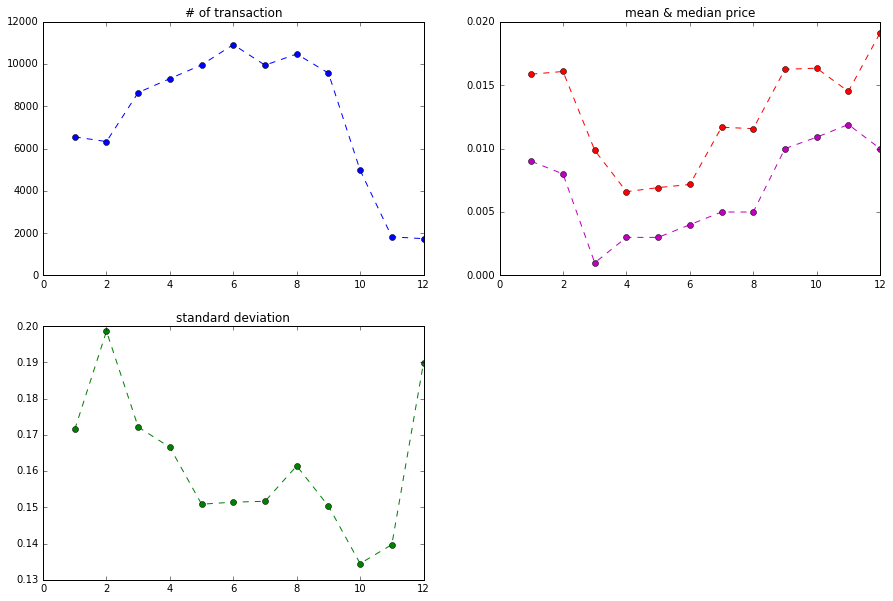

In [31]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(summary_month.index, summary_month['size'], 'bo--')
plt.title('# of transaction')
plt.subplot(2,2,2)
plt.plot(summary_month.index, summary_month['mean'], 'ro--',summary_month.index, summary_month['median'], 'mo--')
plt.title('mean & median price')
plt.subplot(2,2,3)
plt.plot(summary_month.index, summary_month['std'], 'go--')
plt.title('standard deviation')